#  <center>Speech & Natural Language Processing</center>
#  <center>Assignment 2 : Sequence Labelling Models</center>
## Suyash Damle
## 15CS10057

***
## Q1: Discriminative vs Generative Models
***
#### A classification model is said to be Discriminative if it tries to learn and maximize the probability: P(y | x). It takes an input and outputs a classification according to above principle. Classifiers *not* working with probability, but doing similar tasks (such as neural nets) are also loosely called discriminative.


#### On the other hand,  a generative model learns the probability:  P(x, y). It could start generating output from a single or no input, by assuming a default state.

#### So :

- #### Neural Net:  Discriminative
- #### SVM : Discriminative
- #### Logistic Regressor : Discriminative
- #### Naive Bayes: Discriminative
- #### LDA : Generative
- #### Gaussian Mixture Model: Generative
- #### Decision Tree : Discriminative
- #### GANs : Generative


In [4]:
import numpy as np
import nltk
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
import re
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
import math

from sklearn.metrics import accuracy_score #just to calculate the accuracy score


### Data Import

In [33]:
sents=brown.tagged_sents(tagset='universal')
sents=[sentence for sentence in sents]  # the entire corpus - sentences as collection of (words,tags). The NLTK...
                                        # ...  list types are custom "lazy" types and could not be directly edited
sents_train=sents[:-100]
sents_test=sents[-100:]
for sentence in sents_train:
    sentence.insert(0,(None,'START'))
    #sentence.append((None,'END'))
print (len(sents_train))
print (len(sents_test))
print (sents_train[-2:])

57240
100
[[(None, 'START'), ('In', 'ADP'), ('this', 'DET'), ('work', 'NOUN'), (',', '.'), ('his', 'DET'), ('use', 'NOUN'), ('of', 'ADP'), ('non-color', 'NOUN'), ('is', 'VERB'), ('startling', 'ADJ'), ('and', 'CONJ'), ('skillful', 'ADJ'), ('.', '.')], [(None, 'START'), ('The', 'DET'), ('sweep', 'NOUN'), ('of', 'ADP'), ('space', 'NOUN'), (',', '.'), ('the', 'DET'), ('delicate', 'ADJ'), ('counterbalance', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('white', 'ADJ'), ('masses', 'NOUN'), (',', '.'), ('the', 'DET'), ('over-all', 'ADJ'), ('completeness', 'NOUN'), ('and', 'CONJ'), ('unity', 'NOUN'), (',', '.'), ('the', 'DET'), ('originality', 'NOUN'), ('and', 'CONJ'), ('imagination', 'NOUN'), (',', '.'), ('all', 'PRT'), ('entitle', 'VERB'), ('it', 'PRON'), ('to', 'PRT'), ('be', 'VERB'), ('called', 'VERB'), ('an', 'DET'), ('authentic', 'ADJ'), ('masterpiece', 'NOUN'), ('.', '.')]]


### Creating required data collections

In [6]:
word_dict={}
tag_dict={}
tag_bigram_dict={}
tag_obs_dict={}
for sentence in sents_train:
    for x in sentence:
        word=x[0]
        tag=x[1]
        if word not in word_dict:
            word_dict[word]=0
        if tag not in tag_dict:
            tag_dict[tag]=0
        if (tag,word) not in tag_obs_dict:
            tag_obs_dict[(tag,word)]=0
            
        word_dict[word]+=1
        tag_dict[tag]+=1
        tag_obs_dict[(tag,word)]+=1

    for x in nltk.bigrams(sentence):
        tag1=x[0][1]
        tag2=x[1][1]
        if (tag1,tag2)not in tag_bigram_dict:
            tag_bigram_dict[(tag1,tag2)]=0
            
        tag_bigram_dict[(tag1,tag2)]+=1



***
## Q2 : The HMM Model
***

#### Creating function to train the HMM model

In [40]:
# Global variables
tag_bigram_counts={}
tag_obs_counts={}

In [41]:
def train_hmm(k=1):
    # uses Laplacian Smoothing with the parameter k supplied
    # needs the data created in previous stage
    global tag_bigram_counts,tag_obs_counts
    
    states_size=len(tag_dict)
    vocab_size=len(word_dict)
    tag_bigram_dict_new=tag_bigram_dict.copy()
    tag_obs_dict_new=tag_obs_dict.copy()

    
    for token in tag_bigram_dict_new:
        t1=token[0]
        if t1 not in tag_bigram_counts:
            tag_bigram_counts[t1]=0
        tag_bigram_counts[t1]+=tag_bigram_dict_new[token]
        
    for token in tag_obs_dict_new:
        t1=token[0]
        if t1 not in tag_obs_counts:
            tag_obs_counts[t1]=0
        tag_obs_counts[t1]+=tag_obs_dict_new[token]
        
        
    for token in tag_bigram_dict_new:
        t1=token[0]
        tag_bigram_dict_new[token]+=k
        tag_bigram_dict_new[token]/=(float(tag_bigram_counts[t1])+k*states_size)
        if tag_bigram_dict_new[token]>1:
            print(token, tag_bigram_dict_new[token])
    tag_bigram_dict_new['DEFAULT_VAL']=1.0/states_size
        
    for token in tag_obs_dict_new:
        t1=token[0]
        t2=token[1]
        tag_obs_dict_new[(t1,t2)]+=k
        tag_obs_dict_new[(t1,t2)]/=(float(tag_obs_counts[t1])+k*states_size)
    tag_obs_dict_new['DEFAULT_VAL']=1.0/states_size
        
    return tag_bigram_dict_new,tag_obs_dict_new

#### Function to test HMM using Viterbi Algorithm

In [42]:
def viterbi_predict(trans_prob,obs_prob,string,k=1):
    '''
    trans_prob: the dict of <state_i, state_j> tuples
    obs_prob: the dict of <state, observation> tuples
    string: a list of words of the required sentence in the right order
    '''
    states_size=len(tag_dict)
    vocab_size=len(word_dict)
    tags_list=list(tag_dict.keys())
    mat=np.zeros((len(string),states_size))
    mat_backtrack=np.zeros((len(string),states_size))
    
    #### initialization phase - for size=0 row ##########
    for idx in range(states_size):
        tuple1=('START',tags_list[idx])
        tuple2=(tags_list[idx],string[0])
        tr_prob=0.
        ob_prob=0.
        if tuple1 in trans_prob:
            tr_prob=trans_prob[tuple1]
        else:
            tr_prob=0.
            
        if tuple2 in obs_prob:
            ob_prob=obs_prob[tuple2]
        else:
            ob_prob=(1.0*k)/(tag_obs_counts[tags_list[idx]]+k*states_size)
        
    
        mat[0][idx]=np.log2(tr_prob*ob_prob)
        mat_backtrack[0][idx]=tags_list.index('START')
    ####################################################
    
    #### Dynamic Programming phase begins here ##########
    for str_idx in range(1,len(string)):
        for state_idx_l,state_l in enumerate(tags_list):  # future state - l
            max_val=-1*np.inf
            max_val_state=-1
            for state_idx_k,state_k in enumerate(tags_list):  # prev. state - k
                term1=mat[str_idx-1][state_idx_k]
                term2=0.
                term3=0.
                
                if (state_k,state_l) in trans_prob:
                    term2=trans_prob[(state_k,state_l)]
                else:
                    term2=(k*1.)/(tag_bigram_counts[state_k]+k*states_size)
                    
                if(state_l,string[str_idx]) in obs_prob:
                    term3=obs_prob[(state_l,string[str_idx])]
                else:
                    term3=(k*1.)/(tag_obs_counts[state_k]+k*states_size)
                    
                term_final=term1+np.log2(term2)+np.log2(term3)
                
                if term_final > max_val:
                    max_val=term_final
                    max_val_state=state_idx_k
                    
            mat[str_idx][state_idx_l]=max_val
            mat_backtrack[str_idx][state_idx_l]=max_val_state
    #########################################################
    
    
    #### Back-Tracking from here #############################
    # the final state is being taken as implicit
    
    tags_sequence=[]
    this_state_idx=np.argmax(mat[len(string)-1])
    this_state_val=tags_list[this_state_idx]
    tags_sequence.insert(0,this_state_val)
    prev_state_idx=mat_backtrack[len(string)-1][this_state_idx]
    for str_idx in range(len(string)-2,-1,-1):
        this_state_val=tags_list[int(prev_state_idx)]
        tags_sequence.insert(0,this_state_val)
        prev_state_idx=mat_backtrack[str_idx][int(prev_state_idx)]
        
    return tags_sequence
    

#### The controller function for the HMM training and testing

In [43]:
def driver_hmm(k_val=1):
    '''
    The main controller function
    '''
    np.seterr(divide='ignore')
    k=k_val
    trans_prob, obs_prob=train_hmm(k=k)
    true_tag=[]
    predicted_tags=[]
    for sentence in sents_test:
        test_sentence=[]
        for token in sentence:
            test_sentence.append(token[0])
            true_tag.append(token[1])
        pred_tags=viterbi_predict(trans_prob,obs_prob,test_sentence,k=k)
        predicted_tags.extend(pred_tags)
    accuracy=accuracy_score(true_tag,predicted_tags)
    return accuracy

0.9332213355732886


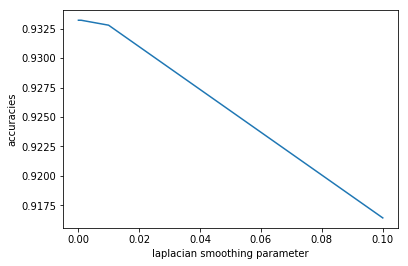

In [44]:
k_vals=[0.0001,0.001,0.01,0.1]
accuracy_scores=[]
for k_val in k_vals:
    accuracy_scores.append(driver_hmm(k_val=k_val))
    
plt.plot(k_vals,accuracy_scores)
plt.xlabel('laplacian smoothing parameter')
plt.ylabel('accuracies')
plt.show

print(accuracy_scores[0]) # printing the best value

***

## Q 3 : The CRF model
***


#### The following features are added : 

- *prefix-1, prefix-2, prefix-3* :  The prefix upto the stated length of the word. Appearance of modifiers in the prefix, such as "un-"(as in uncomfortable) or "a-" (as in asymmetrical) or "pre-", etc often indicate **Adjective** or **Adverbs**


- *suffix-1, suffix-2, suffix-3* : For the same reason as above - presence of suffixes could indicate different POSs: eg: "-ity" as in "inactivity" indicates **Noun**, "-ness" as in "sadness" indicates **Adjective**


- *is_first* : Whether the word is the first word in the sentence. First words in english are usually **Nouns or Pronouns or Determinants**


- *is_last* : Sentences usually end with object of the verb; ie, they are likely to be **Nouns**


- *is_upper* : Whether the word is in uppercase. Would indicate acronyms - usually **Nouns**


- *is_title* : Whether first letter is capitalized. Indicates either beginning of sentence or **Proper Noun**


- *is_digit* : Universal Tagset has **NUM** tag for numerical data


- *prev-1* : The previous word (if existent). The preceding word could be very helpful in determining this word's tag: an article could indicate the beginning of a noun phrase. So, this word is likely to be **Noun or Adjective or Pronoun**


- *prev-1_is_title* :  Whether the previous word has capitalized first letter


- *prev-1_is_upper, prev-1_is_digit* : Whether the previous words is in uppercase / is numerical.


- *next-1, and its features* : The very next word. As before, the next word and its features are helpful.

- *next-2  &  prev-2* : The next-to-next  and the prev-to-prev  terms

In [7]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [23]:
def word_features(sent,idx,features_list=None, bias=1.):
    word=sent[idx]
    
    #The list of all available features. These would be added one-by-one to test their effectiveness
    all_features={
        'bias':bias,
        'word':word.lower(),
        'prefix-1': word.lower()[0],
        'prefix-2': word.lower()[:2],
        'prefix-3': word.lower()[:3],
        'suffix-1': word.lower()[-1],
        'suffix-2': word.lower()[-2:],
        'suffix-3': word.lower()[-3:],
        'is_first': idx==0,
        'is_last' : idx==len(sent)-1,
        'is_upper': word.isupper(),
        'is_title': word.istitle(),
        'is_digit': word.isdigit(),
        'prev-2':sent[idx-2].lower() if idx>1 else '',
        'next-2':sent[idx+2].lower() if idx<len(sent)-2 else ''
    }
    
    # features corresponding to prev word
    if idx>0:
        word_prev=sent[idx-1]
        all_features.update({
            'prev-1': word_prev,
            'prev-1_is_title':word_prev.istitle(),
            'prev-1_is_upper':word_prev.isupper(),
            'prev-1_is_digit':word_prev.isdigit(),
        })
        
    # features of the next word
    if idx<len(sent)-1:
        word_next=sent[len(sent)-1]
        all_features.update({
            'next-1': word_next,
            'next-1_is_title':word_next.istitle(),
            'next-1_is_upper':word_next.isupper(),
            'next-1_is_digit':word_next.isdigit(),
        })
        
    if features_list is not None:
        # selectively add features and return those
        new_features={}
        new_features['bias']=all_features['bias']  #default feature
        new_features['word']=all_features['word']  #default feature
        for feat  in features_list:
            if feat in all_features:
                new_features[feat]=all_features[feat]
        
        return new_features
        
    return all_features

def sent_features(sent,features=None):    
    '''
    Returns the set of features for this sentence
    '''
    sentence=[]
    for idx,(word,tag) in enumerate(sent):
        if word is None:
            continue
        sentence.append(word)
    return [word_features(sentence,i,features_list=features) for i in range(len(sentence))]

def sent_labels(sent):
    '''
    Returns the lables sequence for this sentence
    '''
    pos_tags=[]
    for idx,(word,tag) in enumerate(sent):
        if word is None:
            continue
        pos_tags.append(tag)
    return pos_tags

### Proof of the fact that each of the stated feature adds some accuracy to the model: 


***
- #### We would incrementaly add certain sets of features and find their effect on the performance wrt the base / previous models. 
- #### In the interest of quicker checking, *we could reduce the training sample* and work with smaller sets. Only relative performances would then be considered.
***

#### Helper Function to help with the testing of incremental addition of features

In [31]:
def crf_feature_test(features,c1=0.1,c2=0.1,limit=20000):
    LIMIT=limit # working with only 'LIMIT' no. of training samples
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]

    X_train=(sent_features(s,features) for s in sents_train[:LIMIT])
    X_test=(sent_features(s,features) for s in sents_test)
    y_train=[sent_labels(s) for s in sents_train[:LIMIT]]
    y_test=[sent_labels(s) for s in sents_test]

    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=c1,
        c2=c2,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    y_pred=crf.predict(X_test)

    labels=crf.classes_
    accuracy=metrics.flat_accuracy_score(y_test,y_pred)
    
    return accuracy,y_test,y_pred

***
### Testing feature sets incrementally: 

#### MODEL 0 : The base model - only the bias and word itself

In [18]:
accuracy_0,_,_=crf_feature_test([])
print(accuracy_0)

0.9307013859722806


#### MODEL 1 : Adding : *Prefix & Suffix* Features to the base model

In [20]:
features=['prefix-1','prefix-2','prefix-3','suffix-1','suffix-2','suffix-3']
accuracy_1,_,_=crf_feature_test(features)
print(accuracy_1)

0.9449811003779924


#### MODEL 2 :  Adding : *is_first,  is_last,  is_digit,  is_upper,  is_title *

In [21]:
features=['prefix-1','prefix-2','prefix-3','suffix-1','suffix-2','suffix-3','is_first','is_last','is_digit','is_upper','is_title']
accuracy_2,_,_=crf_feature_test(features)
print(accuracy_2)

0.9458210835783284


#### MODEL 3 : Adding: *prev-1,  prev-1_is_upper,  prev-1_is_digit,  prev-1_is_title*

In [24]:
features=['prefix-1','prefix-2','prefix-3','suffix-1','suffix-2','suffix-3','is_first','is_last','is_digit',
          'is_upper','is_title','prev-1','prev-1_is_digit','prev-1_is_title','prev-1_is_upper']
accuracy_3,_,_=crf_feature_test(features)
print(accuracy_3)

0.9517009659806804


#### MODEL 4 : Adding:  *next-1, next-1_is_digit,  next-1_is_upper,  next-1_is_title  *

In [25]:
features=['prefix-1','prefix-2','prefix-3','suffix-1','suffix-2','suffix-3','is_first','is_last','is_digit',
          'is_upper','is_title','prev-1','prev-1_is_digit','prev-1_is_title','prev-1_is_upper',
         'next-1','next-1_is_digit','next-1_is_title','next-1_is_upper']
accuracy_4,_,_=crf_feature_test(features)
print(accuracy_4)

0.9525409491810164


#### MODEL 5 : Adding : *next-2,  prev-2* : ie, next-to-next  & prev-to-prev words

In [26]:
features=['prefix-1','prefix-2','prefix-3','suffix-1','suffix-2','suffix-3','is_first','is_last','is_digit',
          'is_upper','is_title','prev-1','prev-1_is_digit','prev-1_is_title','prev-1_is_upper',
         'next-1','next-1_is_digit','next-1_is_title','next-1_is_upper','prev-2','next-2']
accuracy_5,_,_=crf_feature_test(features)
print(accuracy_5)

0.9538009239815204





***
- #### We could clearly see that as more sets of specific features are added, the accuracy (& hence, its performance) increases

- #### The overall variation might depend on the way the features are incrementally added; however, the fact remains that adding these features does help the model
***


### Checking best values of L1 & L2 smoothing parameters:

- #### As before, we would run the process on a small train set (10k) for different values of c1 and c2 individually and do a *grid search*

In [28]:
c1_list=[0.0001,0.001,0.01,0.1]
c2_list=[0.0001,0.001,0.01,0.1]
for c1 in c1_list:
    for c2 in c2_list:
        # running test with ALL features
        acc,_,_=crf_feature_test(None,c1=c1,c2=c2,limit=10000)
        print("c1 = ",c1,"; c2 = ",c2," : accuracy = ",acc)

c1 =  0.0001 ; c2 =  0.0001  : accuracy =  0.9399412011759765
c1 =  0.0001 ; c2 =  0.001  : accuracy =  0.9428811423771525
c1 =  0.0001 ; c2 =  0.01  : accuracy =  0.9470810583788324
c1 =  0.0001 ; c2 =  0.1  : accuracy =  0.9454010919781605
c1 =  0.001 ; c2 =  0.0001  : accuracy =  0.9399412011759765
c1 =  0.001 ; c2 =  0.001  : accuracy =  0.9445611087778244
c1 =  0.001 ; c2 =  0.01  : accuracy =  0.9475010499790004
c1 =  0.001 ; c2 =  0.1  : accuracy =  0.9449811003779924
c1 =  0.01 ; c2 =  0.0001  : accuracy =  0.9487610247795044
c1 =  0.01 ; c2 =  0.001  : accuracy =  0.9479210415791685
c1 =  0.01 ; c2 =  0.01  : accuracy =  0.9470810583788324
c1 =  0.01 ; c2 =  0.1  : accuracy =  0.9449811003779924
c1 =  0.1 ; c2 =  0.0001  : accuracy =  0.9470810583788324
c1 =  0.1 ; c2 =  0.001  : accuracy =  0.9458210835783284
c1 =  0.1 ; c2 =  0.01  : accuracy =  0.9470810583788324
c1 =  0.1 ; c2 =  0.1  : accuracy =  0.9475010499790004


***
### Thus, although variation in accuracy scores is quite small, we nevertheless proceed with the combination that gave us the best performance :

   **c1 = 0.01**

   **c2 = 0.0001**
   
***

   
### Creating and testing a full-fledged model with all features and the c1, c2 values as found above:

In [34]:
acc_final, y_test, y_pred=crf_feature_test(None,c1=0.01,c2=0.0001,limit=len(sents_train))
f1_score=metrics.flat_f1_score(y_test,y_pred,average='weighted')

/home/suyash/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### The final accuracy and f-score for CRF model

In [39]:
print(f1_score)
print("accuracy: ",acc_final)
print(metrics.flat_classification_report(y_test,y_pred))

0.9509121303766002
accuracy:  0.9542209155816883
             precision    recall  f1-score   support

          .       1.00      1.00      1.00       334
        ADJ       0.87      0.89      0.88       140
        ADP       0.95      0.97      0.96       283
        ADV       0.88      0.88      0.88       124
       CONJ       1.00      0.99      0.99        84
        DET       1.00      1.00      1.00       295
       NOUN       0.92      0.96      0.94       483
        NUM       0.95      0.95      0.95        21
       PRON       1.00      0.99      1.00       160
        PRT       0.90      0.89      0.89        70
       VERB       0.97      0.94      0.95       370
          X       0.00      0.00      0.00        17

avg / total       0.95      0.95      0.95      2381



/home/suyash/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


***
## Final Results:

- ### HMM accuracy on 100 test samples : 93.33%
- ### CRF accuracy on 100 test samples : 95.422% ; F-score = 0.9509